# Water release from the mantle

Compute how much water is released into the atmosphere.

In [1]:
from multiprocessing import Pool, cpu_count
import numpy as np
import gplately
from gplately import pygplates
from gplately import tools
import ptt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
import glob, os
from slabdip import SlabDipper
from joblib import Parallel, delayed, cpu_count
%matplotlib inline
# plt.style.use('ggplot')

# common data files
#grid_directory = input_directory+"SRGrids/"
grid_directory = "../Muller2022_InputGrids/"
spreadrate_filename = grid_directory+"SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.1f}Ma.nc"
agegrid_filename = grid_directory+"SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.1f}Ma.nc"

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# output grid resolution - should be identical to input grid resolution!
spacingX, spacingY = 0.2, 0.2
resX, resY = int(360./0.2 + 1), int(180./0.2 + 1)
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)
lonq, latq = np.meshgrid(lon_grid,lat_grid)

# reconstruction time steps and spacing
min_time = 0
max_time = 1000
timestep_size = 1

# reversed (start at max_time, end at min_time)
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)[::-1]

save_output_netcdf = True # !! important
save_output_snapshots = False

In [2]:
gdownload = gplately.download.DataServer("Muller2022", verbose=False)
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use GPlately's DataServer to get coastlines and continents
coastlines, continents, COBs = gdownload.get_topology_geometries()
        

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
gplot = gplately.PlotTopologies(model, coastlines, continents, time=0)

In [3]:
cell_area = tools.lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

In [4]:
import scipy.ndimage as sn

# This works for smoothing arrays with a (4,1000,3) shape.
def median_filter_3d(array, time_window):
    smooth_result = np.zeros_like(array)
    for c in range(array.shape[0]):
        for i in range(3):
            smooth_result[c,:,i] = sn.median_filter(array[c,:,i], size=time_window)
            
    return smooth_result

# This works for smoothing arrays with a 2D, i.e. (1000,3) shape.
def median_filter_2d(array, time_window):
    smooth_result = np.zeros_like(array)
    for i in range(array.shape[-1]):
        smooth_result[:,i] = sn.median_filter(array[:,i], size=time_window)
    
    return smooth_result


def save_xy_data(filename, **kwargs):
    header = ""
    output = []
    for arg in kwargs:
        val = kwargs[arg]
        header += "{},".format(str(arg))
        output.append(val)
    output = np.column_stack(output)
    np.savetxt(filename, output, delimiter=',', fmt='%g', header=header[:-1])

In [5]:
# Register colourmaps

from matplotlib.colors import LinearSegmentedColormap
import os

cmap_dir = "../utils/ScientificColourMaps5/"

def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

subdirs = get_immediate_subdirectories(cmap_dir)

cmap_crameri = dict()
for subdir in subdirs:
    print (subdir)
    cm_data = np.loadtxt(cmap_dir+"{}/{}.txt".format(subdir, subdir))
    cmap_crameri[subdir] = LinearSegmentedColormap.from_list(subdir, cm_data)
    cmap_crameri[subdir+'_r'] = LinearSegmentedColormap.from_list(subdir+'_r', cm_data[::-1])
    plt.colormaps.register(cmap=cmap_crameri[subdir])
    plt.colormaps.register(cmap=cmap_crameri[subdir+'_r'])

acton
bamako
batlow
berlin
bilbao
broc
buda
cork
davos
devon
grayC
hawaii
imola
lajolla
lapaz
lisbon
nuuk
oleron
oslo
roma
tofino
tokyo
turku
vik


## water degassing in the mantle

### Interpolating CO$_{2}$ wt.% lost at depth 

---

Author: Christopher M. Gonzalez

Contact: christophmgonzalez@gmail.com

Phone: +610426940721

---

Purpose: Calculate the amount of CO$_{2}$ lost at depth using a _look-up_ table approach. Uses only standard libraries of numpy and scipy.interpolate.

Reads in gridded `.dat` information as a function of P(ressure), T(emperature), and CO$_2$/H$_2$O wt.% into an array H2OArray_TPZ. Returns the interpolated H2O wt.% at depth


Relevant equations:

$$\phi_{T,P} = A_{\mathrm{Ma}} \times V_{\mathrm{slab}} \times \sin(\delta) $$

Where $\phi$ is the thermal parameter, $A$ - Age of the slab in years, $V_{\mathrm{slab}}$ - Velocity of the slab in km yr$^{-1}$, $\delta$ - slab dip in degrees.

Slab top temperatures are derived from Van Keken et. al (2011) from section 3.1 at the following reference:

> Van Keken, P. E., Hacker, B. R., Syracuse, E. M., & Abers, G. A. (2011). Subduction factory: 4. Depth-dependent flux of H2O from subducting slabs worldwide. Journal of Geophysical Research: Solid Earth, 116(1). https://doi.org/10.1029/2010JB007922

Their logic is that at depth, the temperature of the slab can be reduced to a log-linear Temperature relationship as a function of the thermal parameter ($\phi$) for the following lithologies: Sediments, Volcanics, and the temperature at the Oceanic crustal moho (i.e., the base of the intrusives ~7km depth). <br> Since the an approximation for sub-arc depths (ranges from ~70 - 200 km) with the median ~100-120 km depth from continental-onceanic and intraoceanic arc ranges 90-160 without a clear peak in its distribution (e.g., Schmidt and Poli 2013). 

Total H2O loss can be calculated as follows: 

 CO$_{2}$$_{\mathrm{loss}}$ = CO$_{2}$$_{\mathrm{final}}$ - CO$_{2}$$_{\mathrm{initial}}$

Where the integrated loss of H2O can be calculated as a function of each lithology.

N.B. the following assumptions:
1. H2O loss is only calculated as a point value difference and not as a path function
2. This is an extremely conservative value, meaning H2O loss is due strictly to thermal breakdown and not due to infiltration of water from subjacent lithologies. 
3. All H2O loss in this physically implausible model suggest it is lost in batch process at this depth.
4. Relies on the validity of the thermal parameter and applying some form of uniformitarianism, it is also applicable back in time. 


P, T, [H2O | H2O] wt.% data is calculated on a regular grid of 313 x 313 nodes using the thermodynamic modelling software: Perple_X (Connolly, 2009; http://www.perplex.ethz.ch/).

Perple_X version information: `Perple_X version 6.9.0, source updated October 11, 2020`

```
Grid parameters:
T_{0}: 573 Kelvin
P_{0}: 500 bars
Pressure resolution: 286.85897435897436 bars
Temperature resolution: 3.5256410256410255 Kelvins
```

We use __30 km__ as the thickness of the Serpentinization layer from Faccenda, 2014.


References: 
---

> 1. Connolly, J. A. D. (2009). The geodynamic equation of state: What and how. Geochemistry, Geophysics, Geosystems, 10(10). https://doi.org/10.1029/2009GC002540
> 2. Schmidt, M. W., & Poli, S. (2014). Devolatilization During Subduction. In H. D. Turekian & K. HollandKarl (Eds.), Treatise on Geochemistry (2nd ed., Vol. 4, pp. 669–701). Elsevier. https://doi.org/10.1016/B978-0-08-095975-7.00321-1
> 3. Faccenda, M. (2014). Water in the slab: A trilogy. Tectonophysics, 614, 1–30. https://doi.org/10.1016/j.tecto.2013.12.020



In [6]:
folder_name = "Muller22_Apr21"

bundle_dir = "./H2O_Review_Bundle"
parent_dir = "./H2O_Review_Bundle/{}/".format(folder_name)

figure_dir = parent_dir+"figures"

In [7]:
from scipy.interpolate import RegularGridInterpolator

perplex_filedir = "../utils/loss_of_subducting_H2O_with_depth/Lookuptables/"

lookup_tables = np.empty((4, 313, 313))

for i, table in enumerate(['Sediments/GLOSS_H2O.dat',
                           'Metabasalts/StaudigelVolcanics_H2O.dat',
                           'Intrusives/Intrusives_H2O.dat',
                           'Sublithospheric_Oceanic_mantle/LOSIMAG_H2O.dat']):
    H2OArray_TPZ = np.genfromtxt(perplex_filedir + table, skip_header=12, autostrip=True)
    lookup_tables[i] = H2OArray_TPZ[:,2].reshape(313,313)
    
T_coords = H2OArray_TPZ[:,0].reshape(313,313)[0,:]
P_coords = H2OArray_TPZ[:,1].reshape(313,313)[:,0]

lookup_interp = RegularGridInterpolator((P_coords, T_coords), lookup_tables[i],
                                        method='nearest', bounds_error=False, fill_value=None)

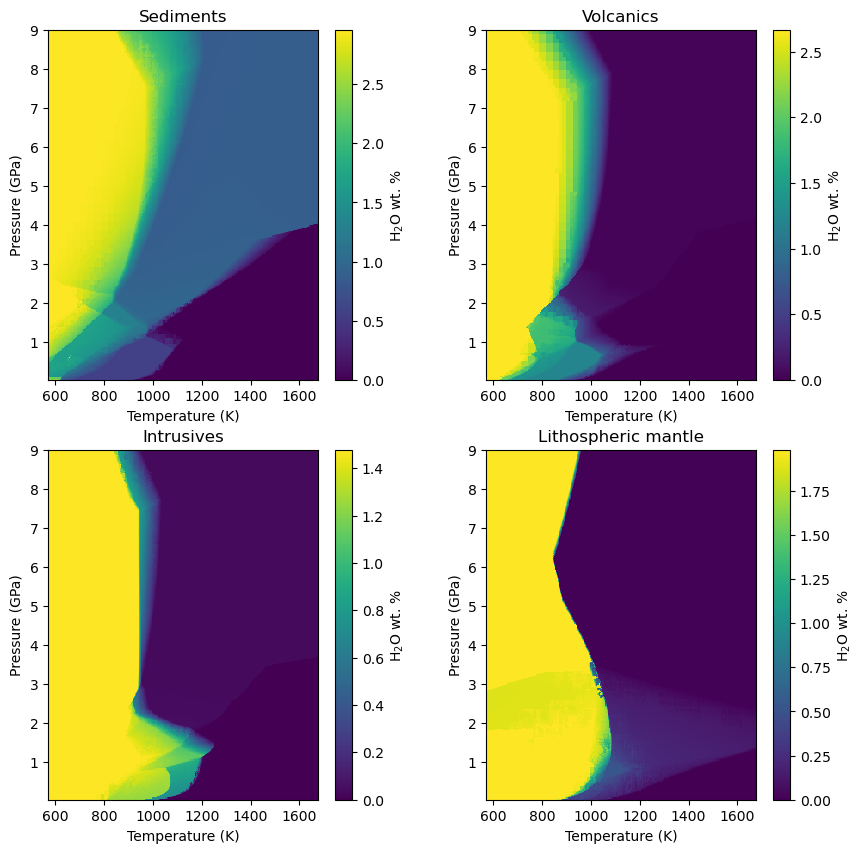

In [8]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(10,10))
plt.subplots_adjust(wspace=0.3)

water_outflux_sources = ["Sediments", "Volcanics", "Intrusives", "Lithospheric mantle"]


for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_title(water_outflux_sources[i])
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Pressure (GPa)')
    vmax = np.percentile(lookup_tables[i], 95)
    im = ax.pcolormesh(T_coords, P_coords/1e4, lookup_tables[i], shading='auto', rasterized=True, vmax=vmax)
    fig.colorbar(im, ax=ax, label='H$_2$O wt. %')
    
# fig.savefig("figures/perplex_H2O_wt_percent.pdf", bbox_inches='tight', dpi=300)
# fig.savefig("figures/perplex_H2O_wt_percent.svg", bbox_inches='tight', dpi=300)
# fig.savefig("figures/perplex_H2O_wt_percent.png", bbox_inches='tight', dpi=300)

In [9]:
verbose = False

def calcPhi(slabAge, slabVelocity, slabDip):
    """
    Take in values of slab dip and return phi, the thermal parameter.
    
    Parameters
    ----------
    slabAge : age of slab (Ma)
    slabVelocity : convergence rate of slab (cm/yr)
    slabDip : dip angle of slab from trench hinge (degrees)
    
    Returns
    -------
    Phi : the thermal parameter
    """
    # phiTP = A(ge) * V(elocity) * sin(\delta)
    # Age: Myrs -> yrs
    slabAge = slabAge * 1e+6
    # Slab velocity: cm/year -> km/yr
    slabVelocity = slabVelocity*1e-5
    # Slab dip calculation, note numpy does things in radians, need to convert to degrees
    slabDip = np.sin(np.deg2rad(slabDip))
    
    if verbose:
        print("Slab age: {} years \n Slab Velocity: {} km yr \n sin(d): {} \n Product: {}".format(
            slabAge, slabVelocity, slabDip, slabAge*slabVelocity*slabDip))

    # Return the product phiTP
    return slabAge*slabVelocity*slabDip

def calcSlabTemperatures(Phi):
    """
    Calculate temperature, equations from Phi
    
    Returns
    -------
    T_sediments : temperature (Celsius) at sediments interface
    T_volcanics : temperature (Celsius) at volcanics interface
    T_Moho      : temperature (Celsius) at the Moho
    """
    T_Sediments = 1331. - 58.6*np.log(Phi)
    T_Volcanics = 1303. - 60.23*np.log(Phi)
    T_Moho      = 1622. - 132.5*np.log(Phi)
    
    if verbose:
        print("TSed: {} \n TVolc: {} \n TMoho: {}".format(T_Sediments, T_Volcanics, T_Moho))
    
    return T_Sediments, T_Volcanics, T_Moho

def sample_lookup_table(P, T, lithology):
    """
    Interpolation function. Takes in the approximated Depth to pressure conversion and
    calculated temperature from the slab tops using Van Keken (2011) and the thermal parameter.
    
                                                 0   1    2
    Read in H2O data generated from Perple_X.  [ T,  P,  H2O]
    
    Parameters
    ----------
    P : pressure in bars
    T : temperature in Kelvin
    lithology : lithology ID
        0 = sediments
        1 = metabasalts
        2 = intrusives
        3 = sublithospheric oceanic mantle
        
    Returns
    -------
    H2O : H2O wt. % for a given pressure and temperature from the specified lookup table lithology
    """
    if lithology not in [0,1,2,3]:
        raise ValueError("lithology must be an integer in the range [0,3]")

    lookup_interp.values = lookup_tables[lithology]
    return lookup_interp((P,T))

In [10]:
def wt_bending_serpentinite(dip):
    return np.clip(dip, 0, 90)*1.0/9

### Initialise SlabDipper object

In [11]:
# Initialise SlabDipper object
dipper = SlabDipper()
dipper.model = model

# Set the filename (including path) of the seafloor age and spreading rate grids
dipper.set_age_grid_filename(agegrid_filename)
dipper.set_spreading_rate_grid_filename(spreadrate_filename)

In [12]:

# Lithosphere
lithosphere_bottom_dir = parent_dir+"/Reservoirs/Lithosphere/bottom/"
lithosphere_top_dir = parent_dir+"/Reservoirs/Lithosphere/top/"

# Crust
crust_bound_dir = parent_dir+"/Reservoirs/Crust/bound/"

# Sediments
sediments_bound_dir = parent_dir+"/Reservoirs/Sediment/bound/"


# this relies on a consistent folder structure - don't meddle!

water_components = [lithosphere_bottom_dir,
                    crust_bound_dir,
                    sediments_bound_dir]
headers  = ['lithosphere_bottom',
            'crust_bound',
            'sediment_bound',
            'total']
quantities = ["min", "mean", "max"]


In [13]:
# only currently consider ocean sediments
#sediments_filename = "Data/compacted_sediment_thickness/sed_thick_0.1d_{}.nc"
sediments_filename = grid_directory+"TotalSediment/Muller2022_sed_thick_0.1d_{:.1f}Ma.nc"

input_cdf_filename  = "{}/{}/water_{}_grid_{}.nc"
output_cdf_filename = "{}/{}/stored_water_{}_{}.nc"

# We use this for sediments earlier than 540Ma.
cont_mask_filename = grid_directory+"ContinentalMasks/continent_mask_{:.1f}.nc"

# also save water devolatilised as h5 file
output_subd_folder = parent_dir+"/subduction_timesteps"
os.makedirs(output_subd_folder, exist_ok=True)
output_csv_filename = output_subd_folder+"/subduction_{:04d}Ma.h5"


def reconstruct_slab_storage(reconstruction_time):
    water_subducted      = np.zeros((len(water_components), 3))
    water_slab_storage   = np.zeros((len(water_components), 3))
    water_in_slab        = np.zeros((resY, resX))
    
    df_time = dipper.tessellate_slab_dip(reconstruction_time, tessellation_threshold_radians)
    
    # remove entries that have "negative" subduction
    # this occurs when the subduction obliquity is greater than 90 degrees
    subduction_convergence = np.clip(df_time['vel'], 0, 1e99)

    # area subducted by trenches over 1 Myr
    subduction_surface_area = subduction_convergence * 1e6 * df_time['length']

    # sample AgeGrid
    age_grid = gplately.Raster(filename=agegrid_filename.format(reconstruction_time))
    age_grid.fill_NaNs(inplace=True)
    age_interp = age_grid.interpolate(df_time['lon'], df_time['lat'])
    thickness = gplately.tools.plate_isotherm_depth(age_interp, n=50, tol=1)
    thickness_brittle = gplately.tools.plate_isotherm_depth(age_interp, temp=600, n=50, tol=1)
    
    subduction_dip = np.clip(df_time['slab_dip'], 1, 90)
    
    # serpentinite due to slab dip
    wt_serp = wt_bending_serpentinite(subduction_dip)/100

    # kg/m2 = thickness * H2O wt % * serpentinite wt % * density
    water_dip = (thickness_brittle - 8e3)*(0.13*wt_serp)*2900
    water_dip *= 1e-9 # convert kg/m2 to Mt/m2
    
    # get sediment thickness - past 540Ma, we use the continent masks.
    """
    if reconstruction_time <= 540:
        seds_grid_fname = sediments_filename.format(reconstruction_time)
    else:
        seds_grid_fname = cont_mask_filename.format(reconstruction_time)
    """
    seds_grid_fname = sediments_filename.format(reconstruction_time)
    
    seds_grid = gplately.Raster(filename=seds_grid_fname)
    seds_grid.fill_NaNs(inplace=True)
    sediment_thickness_interp = seds_grid.interpolate(df_time['lon'], df_time['lat'])
        
    ##
    ## Calculate P-T conditions of slab
    ##

    Phi = calcPhi(age_interp, subduction_convergence*100, subduction_dip)
    T_sediments, T_volcanics, T_moho = calcSlabTemperatures(Phi+1e-12)

    # Calculations are for a constant pressure (4.3750 GPa) at 125 km
    # Assumed 9.81 m/s (gravity) and density of 3500 kg/m3
    P = np.full_like(T_sediments, 125e3*9.81*3500e3*1e-8)

    # convert H2O wt % to kg/m3 (multiply by constant density)
    H2O_sediments_bound = sample_lookup_table(P, T_sediments+273.14, lithology=0) * 1700.0/100 # density
    H2O_crust_bound     = sample_lookup_table(P, T_volcanics+273.14, lithology=1) * 3000.0/100 # density
    H2O_mantlelit       = sample_lookup_table(P, T_moho+273.14,      lithology=3) * 3500.0/100

    # integrate by thickness (now kg/m2 H2O)
    H2O_sediments_bound *= sediment_thickness_interp # 100 m thickness
    H2O_crust_bound     *= 7e3 # 7 km thickness
    H2O_mantlelit       *= (thickness-7e3) # lithospheric thickness - 7e3

    # convert kg/m2 to Mt/m2 water
    H2O_sediments_bound *= 1e-9
    H2O_crust_bound     *= 1e-9
    H2O_mantlelit       *= 1e-9
    
    H2O_component = [H2O_mantlelit, H2O_crust_bound, H2O_sediments_bound]
    
    for c, component in enumerate(water_components):
        water_type = headers[c].split('_')[0]
        
        for i, quantity in enumerate(quantities):
            water_grid = gplately.Raster(filename=input_cdf_filename.format(
                                            component, quantity, water_type, reconstruction_time))
            water_grid.fill_NaNs(inplace=True)
            
            if water_type == 'lithosphere':
                # add on lithosphere_top component
                water_grid2 = gplately.Raster(filename=input_cdf_filename.format(
                    lithosphere_top_dir, quantity, water_type, reconstruction_time))
                water_grid2.fill_NaNs(inplace=True)
                water_grid.data += water_grid2.data
                                                
            # interpolate to trenches
            water_interp, (ci, cj) = water_grid.interpolate(df_time['lon'], df_time['lat'], return_indices=True)

            if water_type == "lithosphere":
                # add on water from plate bending
                water_interp += water_dip # Mt/m2

            # calculate subduction flux of water by integrating across area
            water_subducted[c,i] = (water_interp*subduction_surface_area).sum()

            # remaining water is anything left in the slab that hasn't been devolatilised
            water_remaining = np.minimum(H2O_component[c], water_interp)

            # calculate slab storage flux of water by integrating across area
            water_slab_storage[c,i] = (water_remaining*subduction_surface_area).sum()

            # paste onto grid and dilate
            water_in_slab.fill(0)
            water_in_slab[ci,cj] = water_remaining
            # water_in_slab = ndimage.grey_dilation(water_in_slab, (5,5))

            # Clip all values below 0.
            water_in_slab      = np.clip(water_in_slab, 0., None)
            water_slab_storage = np.clip(water_slab_storage, 0., None)
            water_remaining    = np.clip(water_remaining, 0., None)
            water_subducted    = np.clip(water_subducted, 0., None)
            water_interp       = np.clip(water_interp, 0., None)
            
            if save_output_netcdf:
                fname = output_cdf_filename.format(component, quantity, water_type, reconstruction_time)
                gplately.grids.write_netcdf_grid(fname, water_in_slab)
                
                col_subflux = "subduction_flux_{}_{}".format(water_type, quantity)
                col_storage = "slab_storage_{}_{}".format(water_type, quantity)
                df_time = df_time.assign(**{col_subflux:water_interp, col_storage:water_remaining})
        
    if save_output_netcdf:
        df_time.to_hdf(output_csv_filename.format(int(reconstruction_time)), 
                       key='df', mode='w', complevel=9, complib='zlib', index=False)
                
        
    return water_slab_storage, water_subducted

In [14]:
tz_thickness = float(660-410)
tz_max_wt = 3.0

# t/m2 -> wt % H2O


In [15]:
results = Parallel(n_jobs=-2, verbose=1)(
    delayed(reconstruct_slab_storage)(time) for time in reconstruction_times)


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed: 44.4min finished


In [16]:
water_slab_storage = np.empty((len(water_components), reconstruction_times.size, len(quantities)))
water_subducted    = np.empty((len(water_components), reconstruction_times.size, len(quantities)))


for t, reconstruction_time in enumerate(reconstruction_times):
    water_slab_storage[:,t,:] = results[t][0]
    water_subducted[:,t,:]    = results[t][1]

    

### Integrate slab storage

In [17]:
def accumulate_slab_storage(reconstruction_time):
    
    subducted_water_components = np.empty((len(water_components), resY, resX))
    
    for c, component in enumerate(water_components):
        water_type = headers[c].split('_')[0]
        subducted_water_grid = gplately.grids.read_netcdf_grid(
            output_cdf_filename.format(component, "mean", water_type, reconstruction_time))
        subducted_water_components[c] = subducted_water_grid
        
    return subducted_water_components

In [18]:
with Parallel(n_jobs=-3, verbose=1) as parallel:
    cumulative_slab_storage = np.zeros((len(water_components), resY, resX))
    
    split_times = np.array_split(reconstruction_times, cpu_count() - 2)
    
    for times in split_times:
        results = parallel(delayed(accumulate_slab_storage)(time) for time in times)
    
        for slab_storage_components in results:
            cumulative_slab_storage += slab_storage_components  # synchronization barrier

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-3)]: Done 126 out of 126 | elapsed:    9.2s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    8.9s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    8.8s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:    9.8s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-3)]: Don

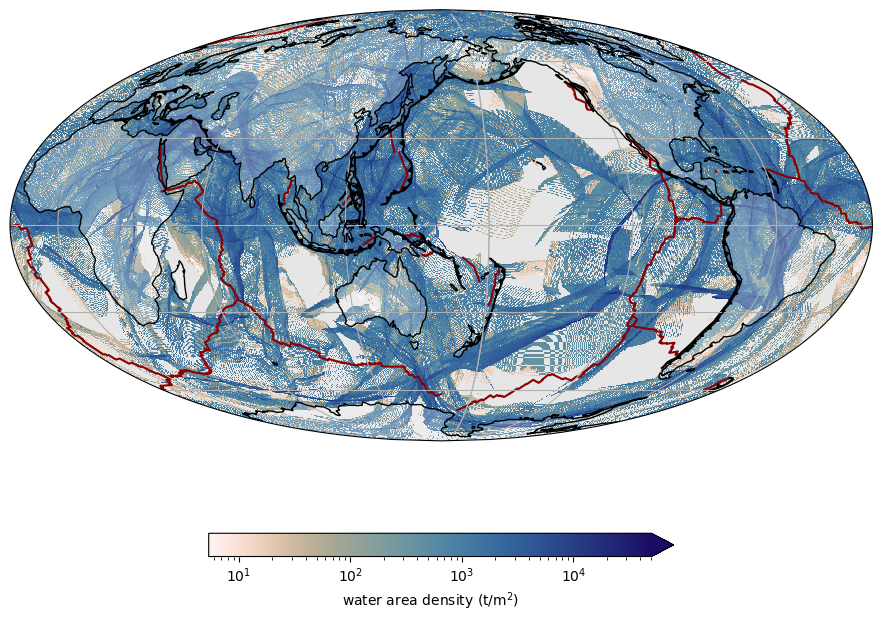

In [19]:
# total subducted water

gplot.time = 0

proj = ccrs.Mollweide(central_longitude=160)
reconstruction_time = 0

total_slab_storage = np.nansum(cumulative_slab_storage, axis=0)


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)
im = ax.imshow(total_slab_storage*1e6, extent=extent_globe, origin='lower', cmap='lapaz_r',
          norm=mcolors.LogNorm(), transform=ccrs.PlateCarree(), interpolation='none')

# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_coastlines(ax, color='w', alpha=0.25, zorder=2)
gplot.plot_ridges_and_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)

ax.coastlines(zorder=3)
ax.gridlines()
fig.colorbar(im, shrink=0.4, label='water area density (t/m$^2$)', extend='max', orientation='horizontal')
fig.savefig(figure_dir+"/cumulative_slab_storage_total.pdf", dpi=300, bbox_inches='tight')

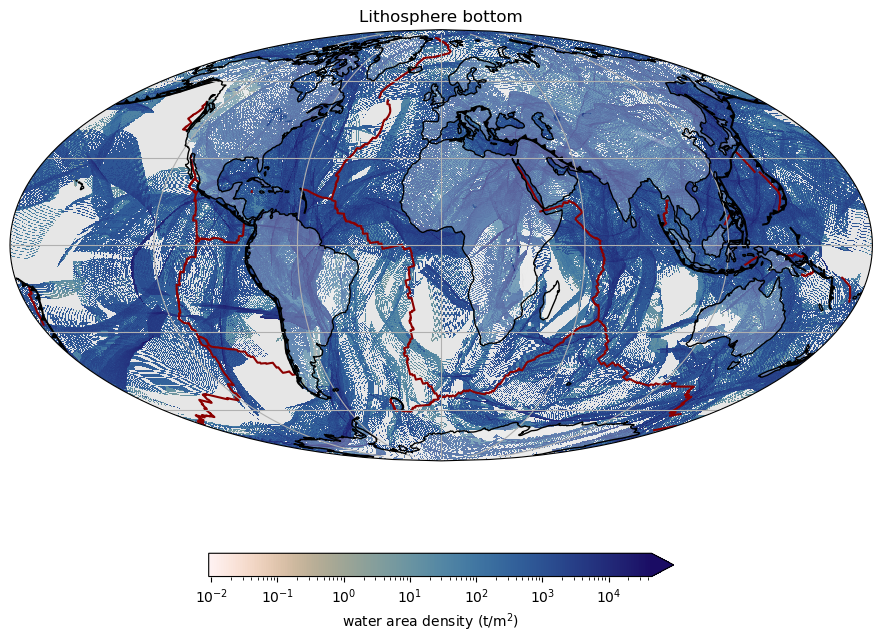

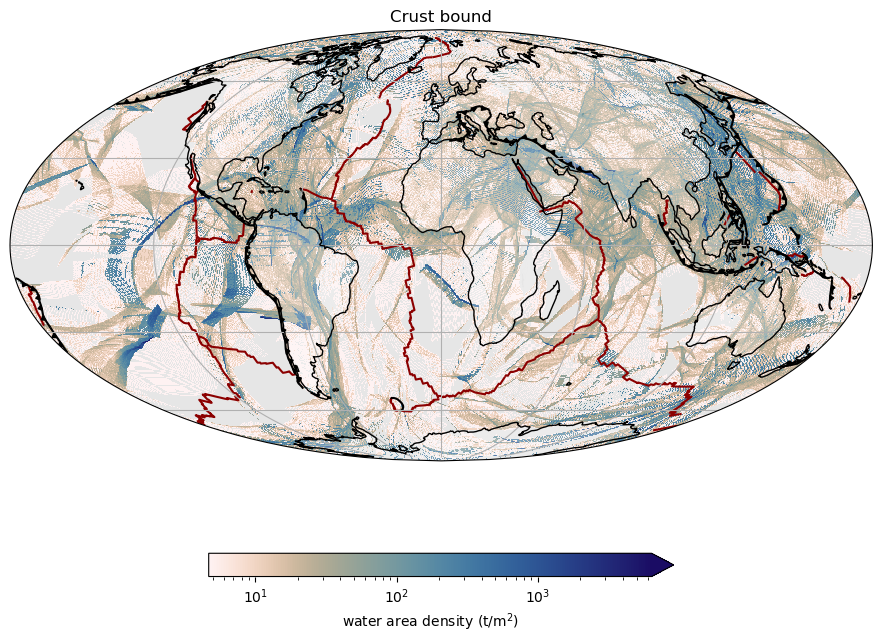

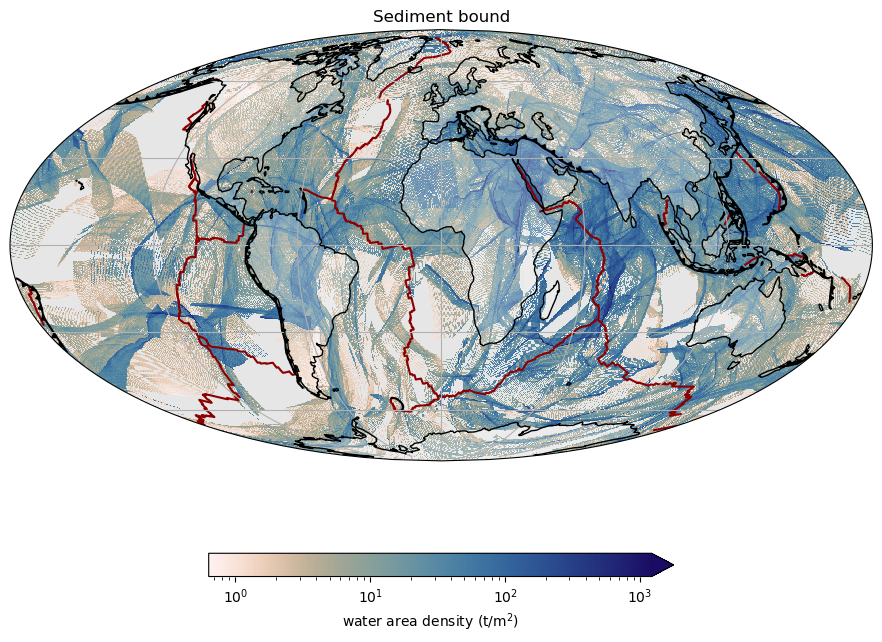

In [20]:
# plot rasters of each water contribution
proj = ccrs.Mollweide()
for c, component in enumerate(water_components):
    
    title = headers[c].replace('_', ' ')
    title = title.capitalize()
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection=proj, title=title)
    ax.set_global()

    ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
              transform=ccrs.PlateCarree(), zorder=0)
    im = ax.imshow(cumulative_slab_storage[c]*1e6, extent=extent_globe, origin='lower', cmap='lapaz_r',
                   norm=mcolors.LogNorm(), transform=ccrs.PlateCarree(), zorder=1, interpolation='none')
    
    # add_continents(ax,  facecolor='0.7', zorder=0)
    gplot.plot_coastlines(ax, color='w', alpha=0.25, zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
    # add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
    gplot.plot_trenches(ax, color='k', zorder=2)
    gplot.plot_subduction_teeth(ax, color='k', zorder=2)

    ax.coastlines(zorder=3)
    ax.gridlines()
    fig.colorbar(im, shrink=0.4, label='water area density (t/m$^2$)', extend='max', orientation='horizontal')
    fig.savefig(figure_dir+"/cumulative_slab_storage_{}.pdf".format(headers[c]), dpi=300, bbox_inches='tight')

## Plots

In [21]:
import pandas as pd

# sum contributions from various water reservoirs
water_subducted_per_year = (water_subducted*1e-6).sum(axis=0) # convert from Mt C/Ma to Mt C/yr
total_water_subducted = np.cumsum(water_subducted_per_year*1e6, axis=0)

headers  = ['lithosphere',
            'crust_bound',
            'sediment_bound',
            'total',
            'cumulative_total']
quantiles = ['min', 'mean', 'max']

data_out = [
    water_subducted[0,:,:]*1e-6,
    water_subducted[1,:,:]*1e-6,
    water_subducted[2,:,:]*1e-6,
    water_subducted_per_year,
    total_water_subducted
]


index = pd.MultiIndex.from_product([headers, quantiles])
df_subduction_influx = pd.DataFrame(np.column_stack(data_out), columns=index, index=reconstruction_times)
df_subduction_influx.to_csv(figure_dir+'/06-subducted-water.csv', index_label='Age (Ma)')

In [22]:
# sum contributions from various water reservoirs
water_stored_per_year = (water_slab_storage*1e-6).sum(axis=0) # convert from Mt C/Ma to Mt C/yr
total_water_stored = np.cumsum(water_stored_per_year*1e6, axis=0)

headers  = ['lithosphere',
            'crust_bound',
            'sediment_bound',
            'total',
            'cumulative_total']
quantiles = ['min', 'mean', 'max']

data_out = [
    water_slab_storage[0,:,:]*1e-6,
    water_slab_storage[1,:,:]*1e-6,
    water_slab_storage[2,:,:]*1e-6,
    water_stored_per_year,
    total_water_stored
]


index = pd.MultiIndex.from_product([headers, quantiles])
df_slab_storage = pd.DataFrame(np.column_stack(data_out), columns=index, index=reconstruction_times)
df_slab_storage.to_csv(figure_dir+'/06-slab-storage.csv', index_label='Age (Ma)')